# t-SNE vs UMAP

It is far to say that the scRNA-Seq field moved from t-SNE to UMAP. Why? 
- scales better
- conservation of global distances

In this dataset you can have a look and process the single-cell data from two covid samples with 2 healthy donors. 

The data itself are again from the https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/32514174/ Nature Medicine paper. 

You need to do the next step, and ensure that you have installed the different libraries.

In [2]:
options(warn=-1)# this command excludes all the warnings

library(Seurat)
library(dplyr)
library(ggplot2)


Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Setup the Seurat Object

You can run through the different steps, or jump to the command readRDS.

In [2]:
# load the data
covid1<-readRDS("Covid_555_1.rds")
covid2<-readRDS("Covid_558.rds")
HC1<-readRDS("HC_HIP044.rds")
HC2<-readRDS("HC_HIP045.rds")


The command above replace the:
the loading of the PBMC dataset
Read10X(data.dir = "pbmc3k/hg19/")
and
CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)

# Standard pre-processing workflow

The steps below encompass the standard pre-processing workflow for scRNA-seq data in Seurat. These represent the selection and filtration of cells based on QC metrics, data normalization and scaling, and the detection of highly variable features.

Yes, you will need to do that for all the four samples... 

In [5]:
covid1[["percent.mt"]] <- PercentageFeatureSet(covid1, pattern = "^MT-")
covid2[["percent.mt"]] <- PercentageFeatureSet(covid2, pattern = "^MT-")
HC1[["percent.mt"]] <- PercentageFeatureSet(HC1, pattern = "^MT-")
HC2[["percent.mt"]] <- PercentageFeatureSet(HC2, pattern = "^MT-")


In the example below, we visualize QC metrics, and use these to filter cells.

    We filter cells that have unique feature counts over 2,500 or less than 200
    We filter cells that have >5% mitochondrial counts

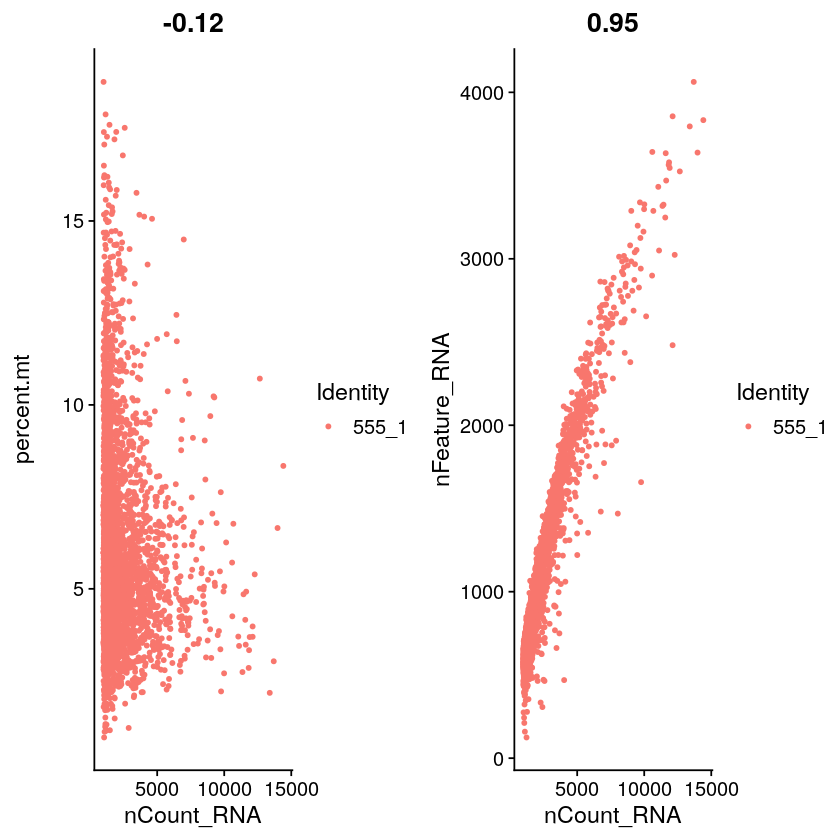

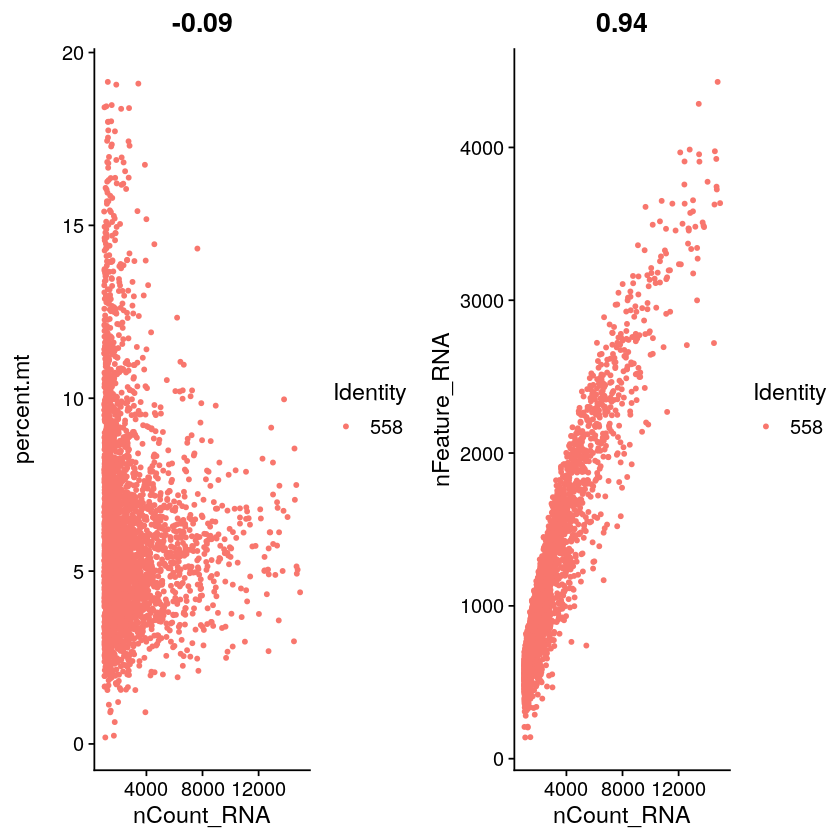

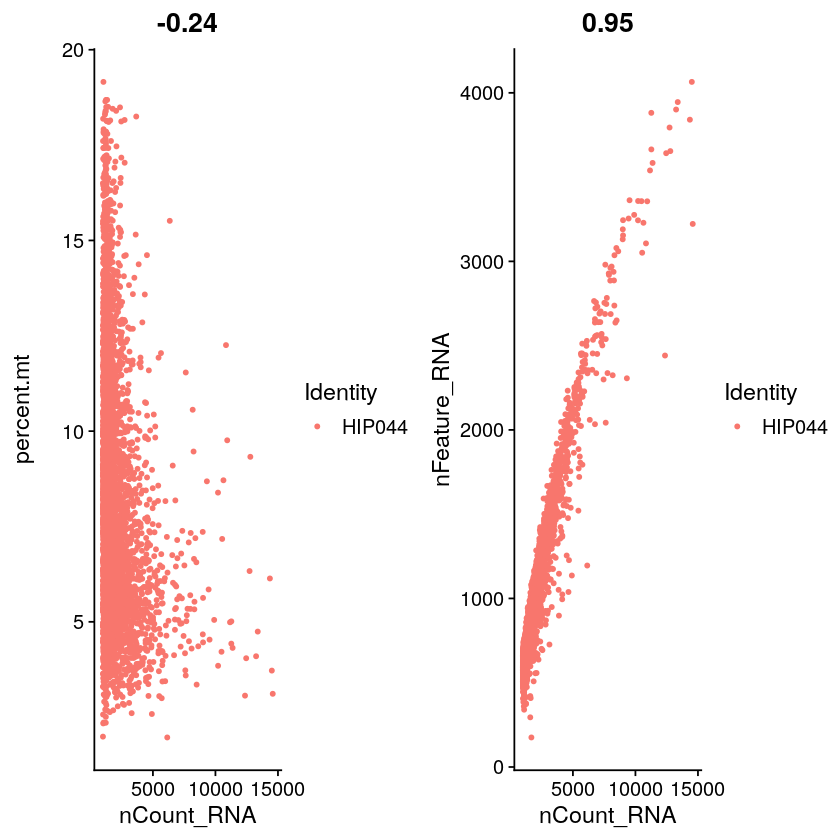

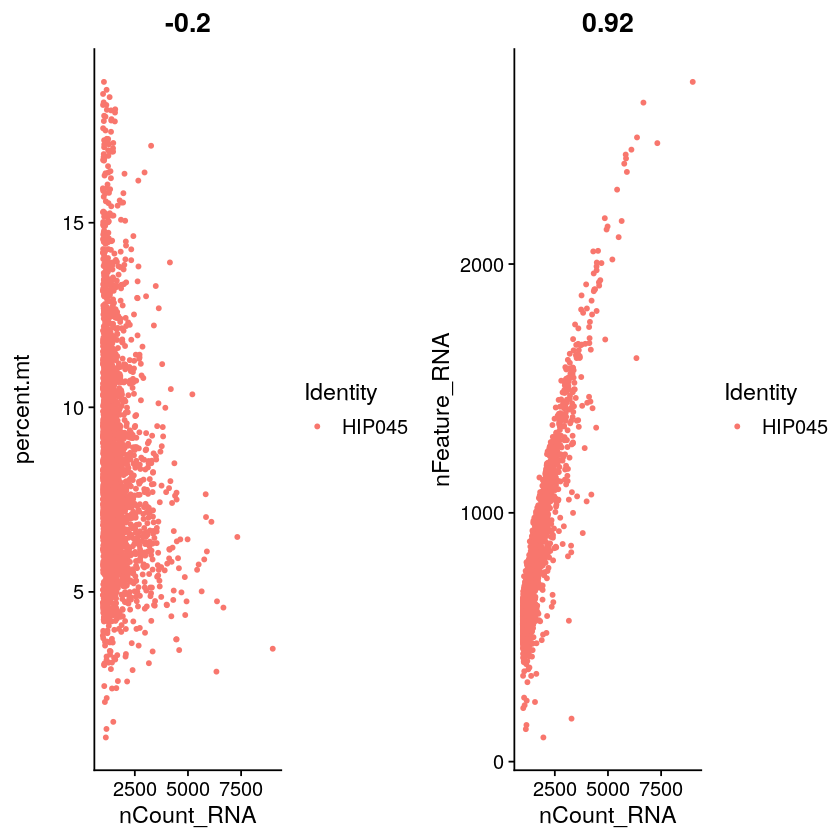

In [6]:
plot1 <- FeatureScatter(object = covid1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(object = covid1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

plot1 <- FeatureScatter(object = covid2, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(object = covid2, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

plot1 <- FeatureScatter(object = HC1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(object = HC1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

plot1 <- FeatureScatter(object = HC2, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(object = HC2, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))# Visualize QC metrics as a violin plot


In [7]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
covid1 <- subset(covid1, subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 10)
covid2 <- subset(covid2, subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 10)

HC1 <- subset(HC1, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)
HC2 <- subset(HC2, subset = nFeature_RNA > 200 & nFeature_RNA < 1800 & percent.mt < 10)




# Normalizing the data

After removing unwanted cells from the dataset, the next step is to normalize the data. Today we are using the SC-transform command.

Could you do the below a bit more efficient? 

In [8]:
   
options(warn=-1)
# run sctransform
covid1 <- SCTransform(covid1, vars.to.regress = "percent.mt", verbose = FALSE)
covid2 <- SCTransform(covid2, vars.to.regress = "percent.mt", verbose = FALSE)

HC1 <- SCTransform(HC1, vars.to.regress = "percent.mt", verbose = FALSE)
HC2 <- SCTransform(HC2, vars.to.regress = "percent.mt", verbose = FALSE)


# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = c(covid1,covid2,HC1,HC2))


# Perform integration

We then identify anchors using the FindIntegrationAnchors() function, which takes a list of Seurat objects as input, and use these anchors to integrate the two datasets together with IntegrateData().

In [9]:
immune.anchors <- FindIntegrationAnchors(object.list = c(covid1,covid2,HC1,HC2), anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7536 anchors

Filtering anchors

	Retained 3731 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8279 anchors

Filtering anchors

	Retained 2865 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7585 anchors

Filtering anchors

	Retained 2582 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6311 anchors

Filtering anchors

	Retained 2674 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6342 anchors

Filtering anchors

	Retained 2716 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6837 anchors

Filtering anchors

	Retained 3703 anchors



In [10]:
# this command creates an 'integrated' data assay
immune.combined <- IntegrateData(anchorset = immune.anchors)

Merging dataset 4 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 4 into 2 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



# Perform an integrated analysis

Now we can run a single integrated analysis on all cells!

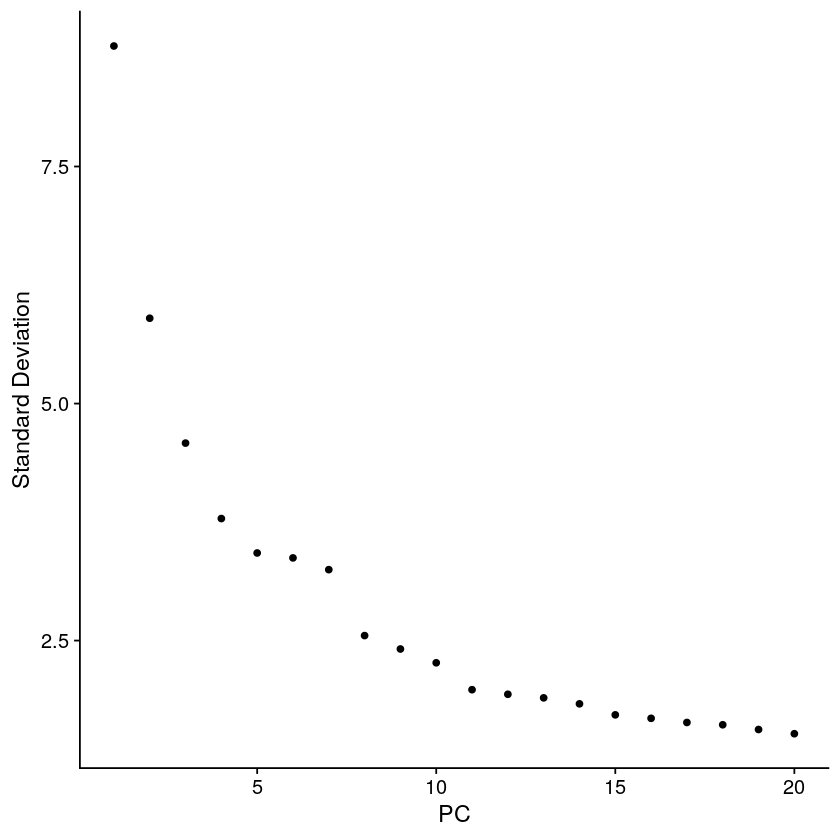

In [12]:
# specify that we will perform downstream analysis on the corrected data note that the original
# unmodified data still resides in the 'RNA' assay

DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 50, verbose = FALSE)
ElbowPlot(immune.combined)

Now, visualise the data in a UMAP. The group.by here would be "Status".

16:45:07 UMAP embedding parameters a = 0.9922 b = 1.112

16:45:07 Read 11498 rows and found 20 numeric columns

16:45:07 Using Annoy for neighbor search, n_neighbors = 30

16:45:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:45:09 Writing NN index file to temp file /tmp/RtmpatgMlD/file5b094fe13a31

16:45:09 Searching Annoy index using 1 thread, search_k = 3000

16:45:14 Annoy recall = 100%

16:45:15 Commencing smooth kNN distance calibration using 1 thread

16:45:16 Initializing from normalized Laplacian + noise

16:45:16 Commencing optimization for 200 epochs, with 512740 positive edges

16:45:23 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11498
Number of edges: 475241

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9495
Number of communities: 12
Elapsed time: 2 seconds


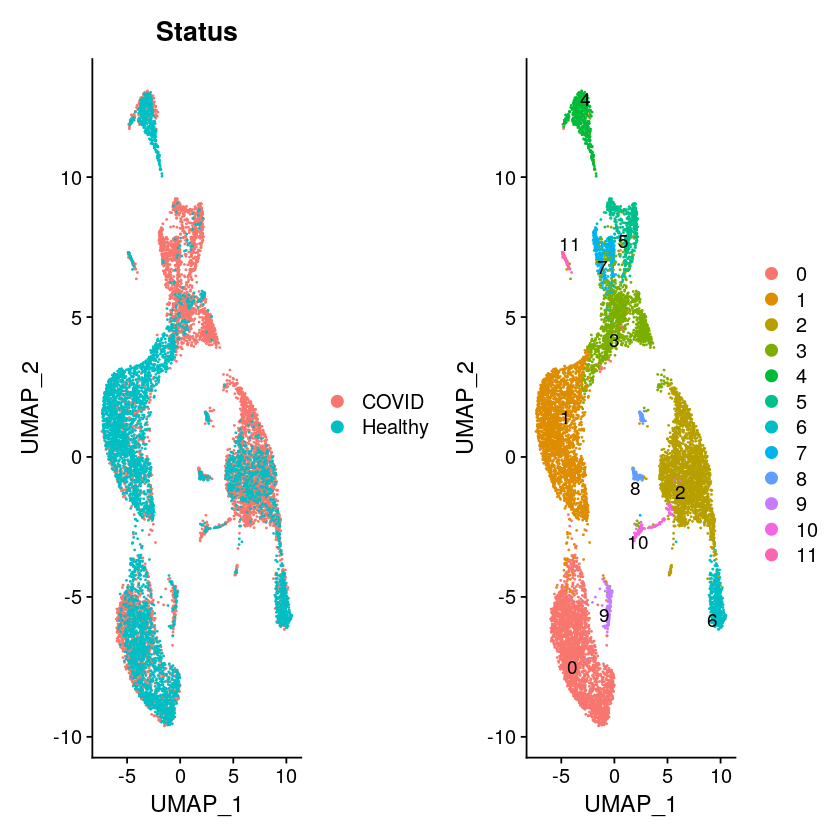

In [13]:
dim<-20
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:dim)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:dim)
immune.combined <- FindClusters(immune.combined, resolution = 0.2)

# Visualization
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "Status")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

The code to run t-SNE in Seurat:

In [ ]:
immune.combined <- RunTSNE(immune.combined)

If you don't want to run the steps before, you can just load the data here:

In [3]:
immune.combined<-readRDS("Anntotated.Immune.Combined.rds")

Plot the single cell data with t-SNE and UMAP

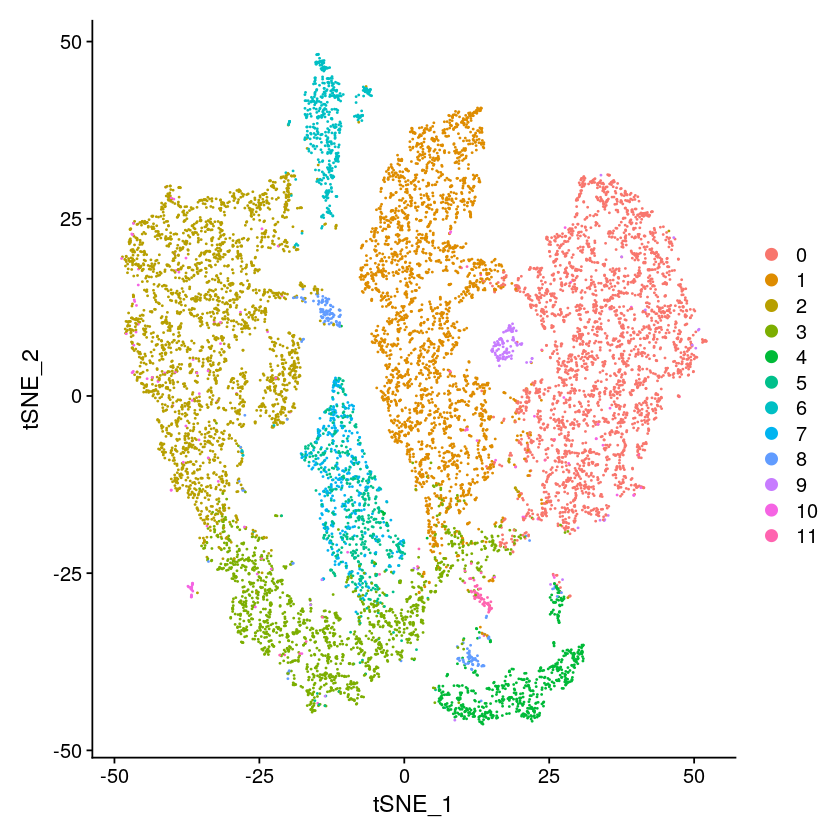

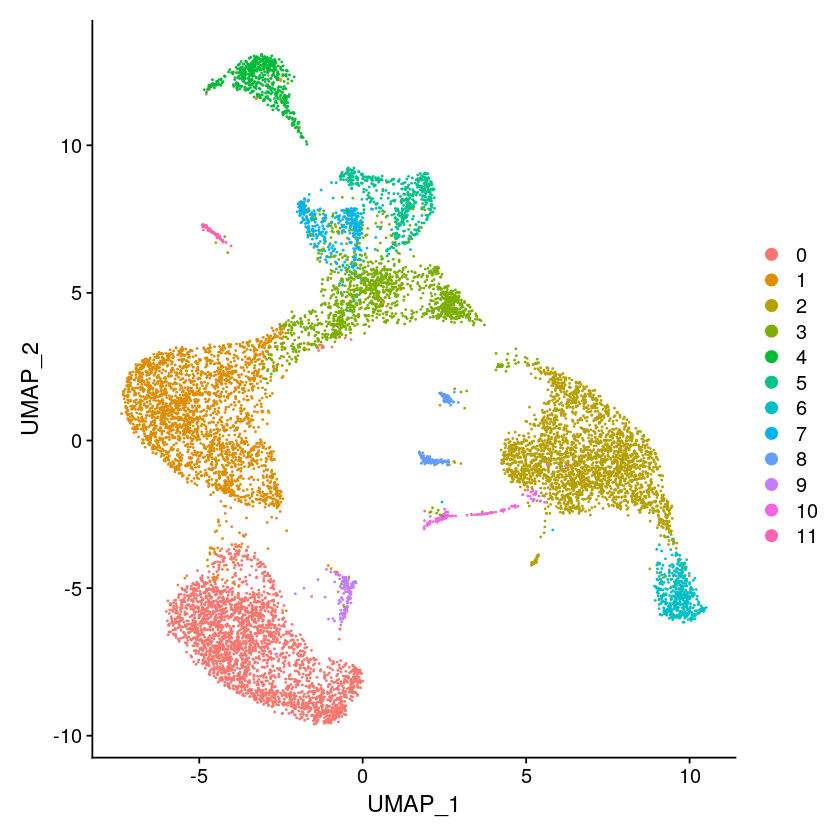

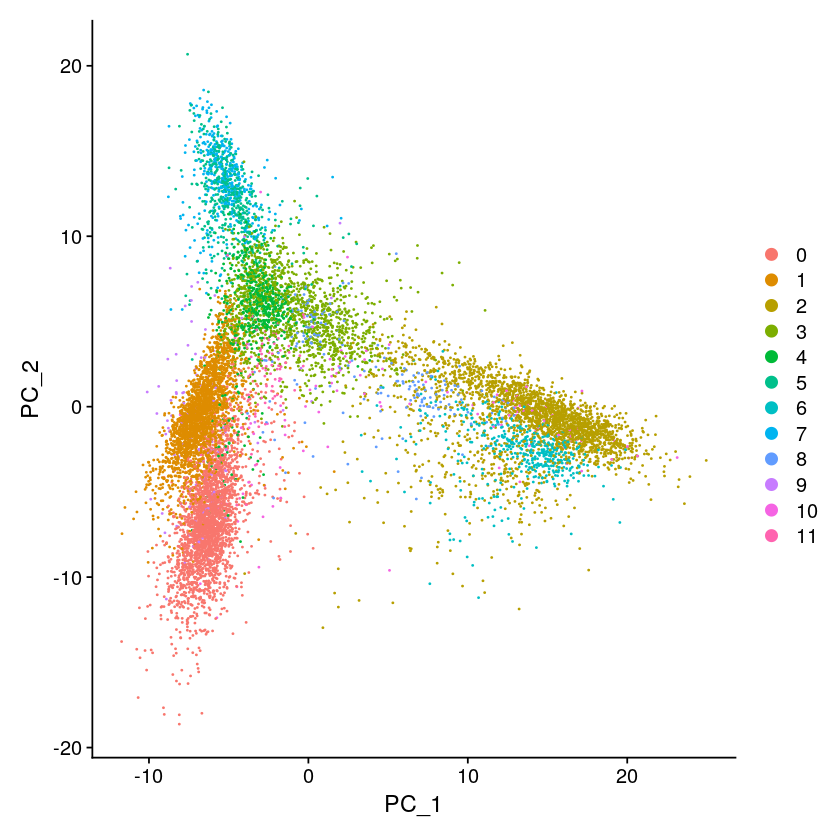

In [4]:
DimPlot(immune.combined, reduction = "tsne")
DimPlot(immune.combined, reduction = "umap")
DimPlot(immune.combined, reduction = "pca")


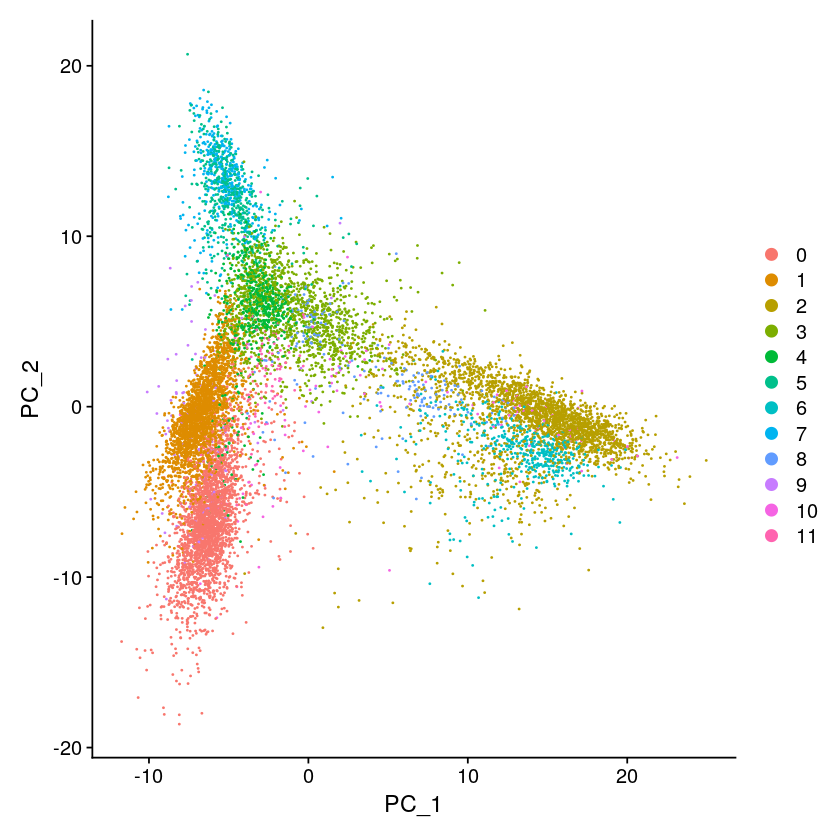

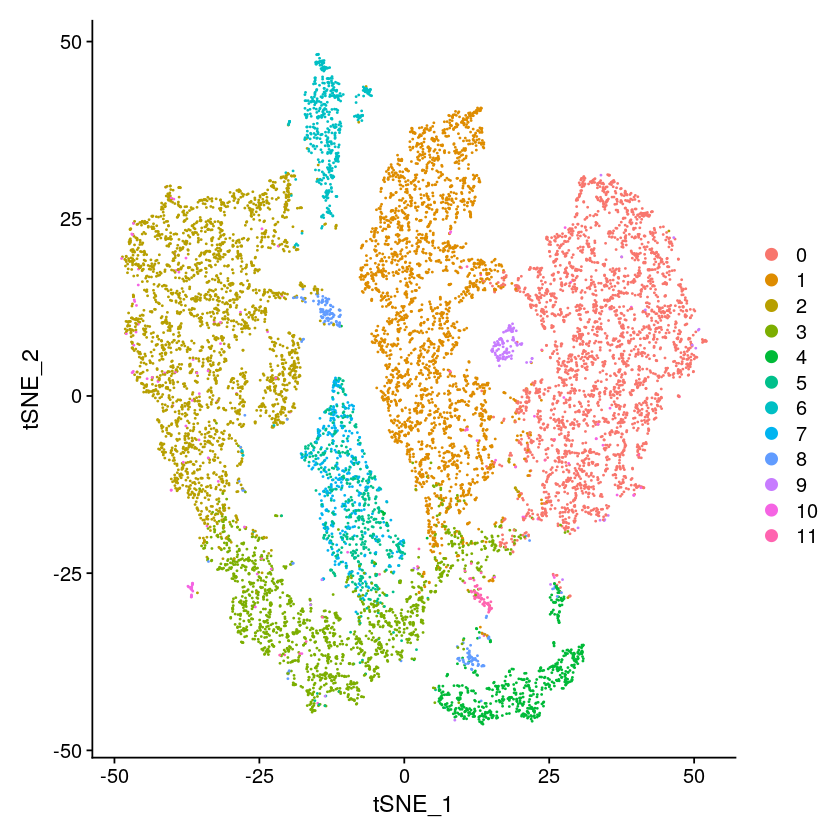

In [26]:
DimPlot(object = immune.combined, reduction = "tsne")

# Annotation of cell types

As previously, you need to find maker genes and try to annotate the different clusters. 

# exclude clusters? 

Maybe some of the cells clusters look weird. Some of them could be noise, and have very few expressed genes. With the following commands you can visualise that:

In [ ]:
immune.combined[["UMI"]] <-  immune.combined$nCount_RNA  # Why divided by 100
FeaturePlot(immune.combined, features = "UMI")
immune.combined[["genes"]] <-  immune.combined$nFeature_RNA
FeaturePlot(immune.combined, features = "genes")

With the command subset you can keep a ranger of clusters:<BR>
Combined.filter <- subset(immune.combined, idents = c("0","1","2","3","7"), invert = FALSE)

# Cell abundance

Due to disease, the frequency of cell types might change between the samples. Here some code to look into it:

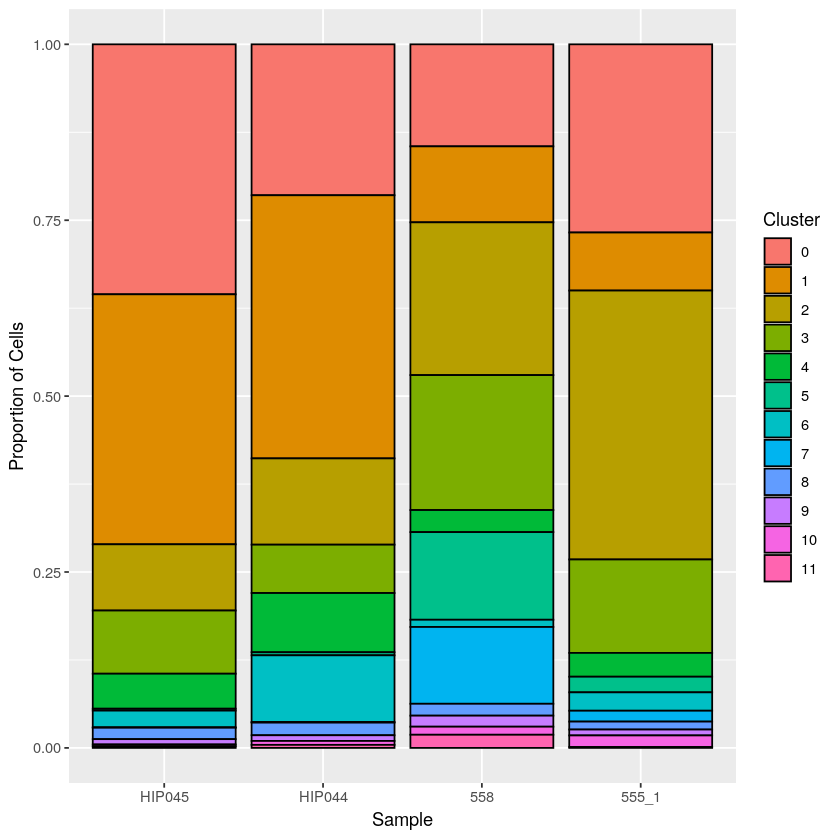

In [27]:
freq_table_sample <- as.data.frame(prop.table(x = table(Idents(immune.combined), immune.combined@meta.data$orig.ident), margin = 2))
ggplot(data=freq_table_sample, aes(x=freq_table_sample$Var2, y=freq_table_sample$Freq, fill=freq_table_sample$Var1)) + geom_bar(stat="identity", color="black") + labs(x="Sample", y="Proportion of Cells", fill="Cluster")  + scale_x_discrete(limits = rev(levels(freq_table_sample$Var2)))



Now that you have an annotated object, maybe better to save it!

In [28]:
saveRDS(immune.combined,"Anntotated.Immune.Combined.rds")

Next, perform the differential expression. <BR>
    <BR>
        Anything interesting? Perform some enrichment for the up- or down-regulated genomes in the CD14 Monocyte and T cell clusters on https://string-db.org/

In [32]:
immune.combined<-readRDS("Anntotated.Immune.Combined.rds")

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11498
Number of edges: 475241

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9583
Number of communities: 11
Elapsed time: 1 seconds


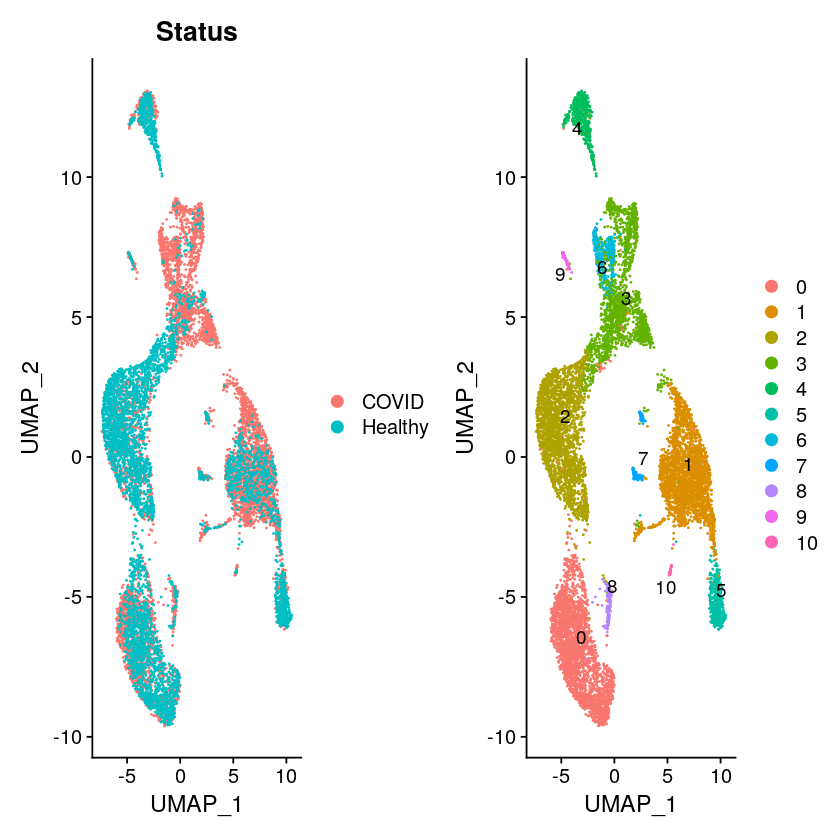

In [33]:
immune.combined <- FindClusters(immune.combined, resolution = 0.15)
# Visualization
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "Status")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2


In [36]:
pbmc.markers <- FindAllMarkers(immune.combined, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,1.627884,0.944,0.576,0.000000e+00,0,PRF1
0.000000e+00,1.359206,0.896,0.585,0.000000e+00,0,CCL5
0.000000e+00,3.453052,0.988,0.739,0.000000e+00,1,VCAN
0.000000e+00,3.209814,0.991,0.766,0.000000e+00,1,LYZ
0.000000e+00,1.310332,0.860,0.590,0.000000e+00,2,IL7R
0.000000e+00,1.084483,0.798,0.522,0.000000e+00,2,LTB
0.000000e+00,3.928129,0.910,0.884,0.000000e+00,3,IGHM
1.462787e-220,2.997781,0.761,0.770,2.925575e-217,3,IGHA1
1.536148e-305,2.167870,0.951,0.344,3.072295e-302,4,MS4A1


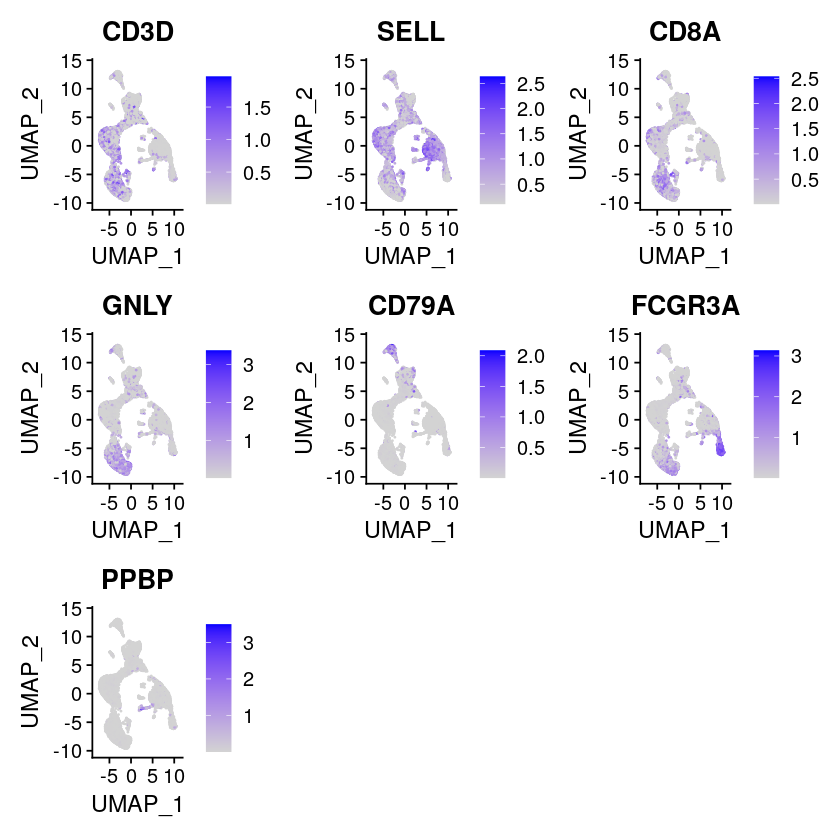

In [34]:
FeaturePlot(immune.combined, features = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", 
    "CCL2", "PPBP"), min.cutoff = "q9")

In [29]:
immune.combined.idents <- c("Need redoing")

names(immune.combined.idents) <- levels(immune.combined)
immune.combined <- RenameIdents(immune.combined, immune.combined.idents )

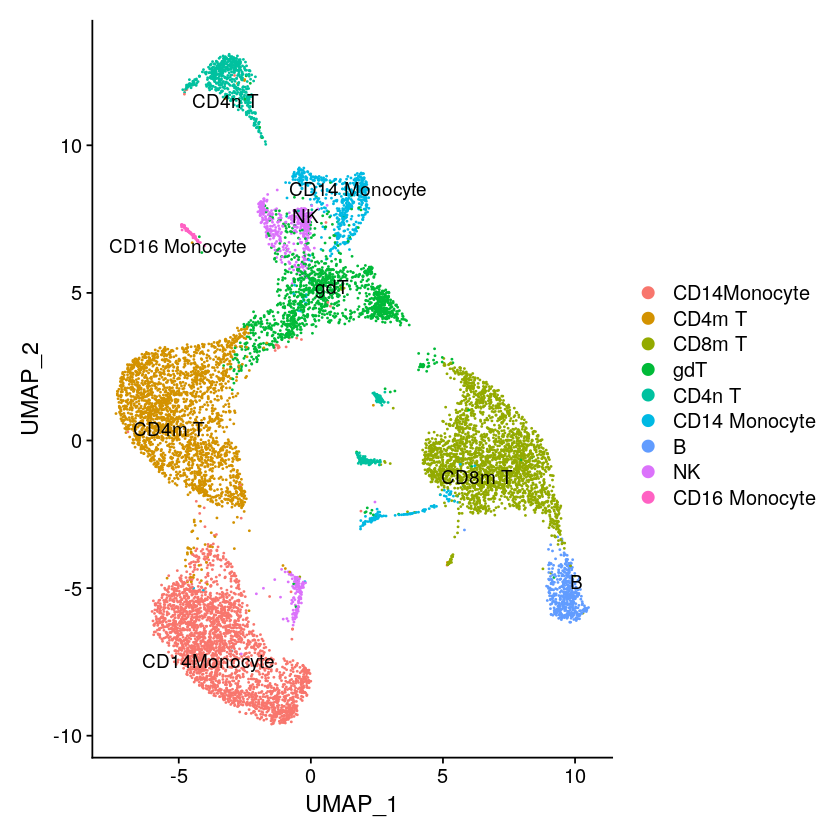

In [30]:

DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)


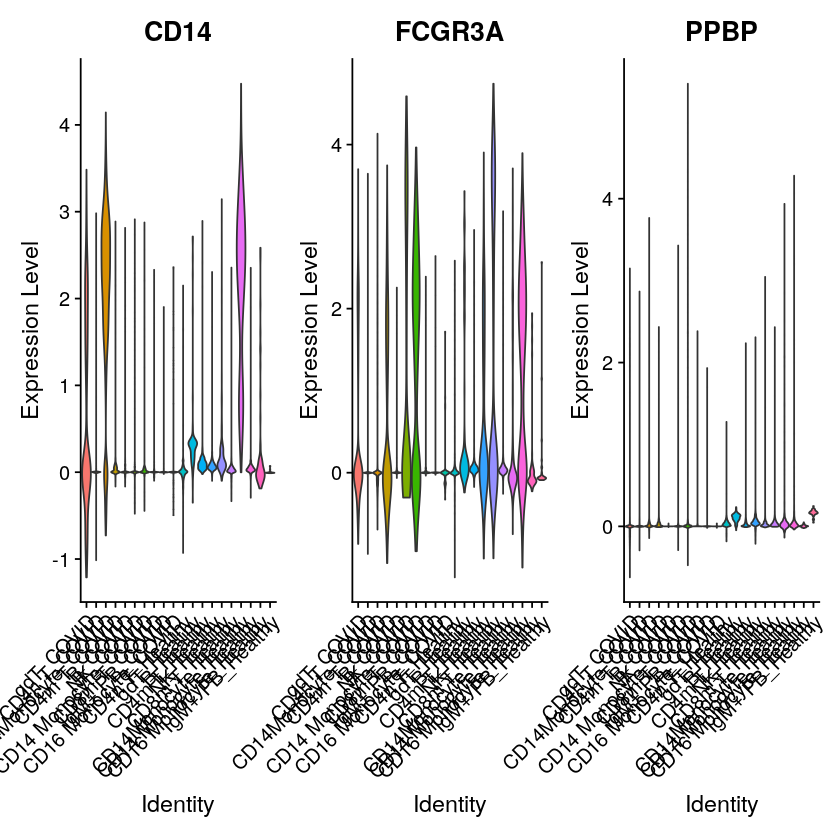

In [41]:
VlnPlot(immune.combined, features = c("CD14", "FCGR3A", "PPBP"), pt.size = 0);
       # , "HBB", "LILRA4", "CD1C", "FCGR3B", "IFITM2"), pt.size = 0)


In [37]:
immune.combined$celltype.Status <- paste(Idents(immune.combined), immune.combined$Status, sep = "_")
immune.combined$celltype <- Idents(immune.combined)
Idents(immune.combined) <- "celltype.Status"


In [39]:
b.CD14monocyte.response <- FindMarkers(immune.combined, ident.1 = "CD14Monocyte_COVID", ident.2 = "CD14Monocyte_Healthy", verbose = FALSE)
head(b.CD14monocyte.response, n = 15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MPO,1.032364e-132,0.2697372,0.458,0.992,2.064729e-129
RNASE1,1.664885e-120,0.3523206,0.464,1.000,3.329770e-117
IGJ,1.568532e-118,0.5865725,0.651,1.000,3.137064e-115
IGHA1,1.131745e-107,0.3956654,0.668,1.000,2.263490e-104
IGLC2,6.686485e-102,0.4854836,0.712,1.000,1.337297e-98
SERPING1,1.095915e-101,0.3801988,0.267,0.985,2.191831e-98
APOBEC3B,8.918038e-98,0.2761915,0.182,0.793,1.783608e-94
IGHG3,3.076119e-95,0.3861547,0.682,1.000,6.152238e-92
MS4A4A,3.470728e-90,0.3501822,0.476,0.954,6.941456e-87


In [40]:
write.table(b.CD14monocyte.response,"b.CD14monocyte.response.txt",sep="\t")

In [31]:
rownames(b.CD14monocyte.response)

[1] "MPO"      "RNASE1"   "IGJ"      "IGHA1"    "IGLC2"    "SERPING1"
 [7] "APOBEC3B" "IGHG3"    "MS4A4A"   "PRF1"     "TCN2"     "MKI67"   
[13] "HIST1H1C" "HERC5"    "IGLC3"    "GZMB"     "IGHG1"    "IGHG2"   
[19] "IGHG4"    "GZMH"     "TLR7"     "LTB"      "FCGR1B"   "GAPT"    
[25] "AQP9"     "CCL5"     "PDIA4"    "FCGR1A"   "GZMA"     "CD83"    
[31] "HIST1H1D" "H1F0"     "IFIT1"    "OTOF"     "HIST1H1E" "SYNE2"   
[37] "IFI27"    "USP28"    "RSAD2"    "HYOU1"    "IGHM"     "CD93"    
[43] "CES1"     "APLP2"    "ANP32E"   "IFITM3"   "SERPINA1" "TIMP1"   
[49] "TLR2"     "F13A1"    "KLF6"     "SIGLEC1"  "JUN"      "CLU"     
[55] "NEAT1"    "TRAM1"    "RGS2"     "TYMP"     "RNASE2"   "CRTAP"   
[61] "PLBD1"    "IFIT3"